In [1]:
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import time
import asyncio

from intrepid_environment.simulator import Simulator
from quadcopter_control.controller import QuadcopterController
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

nest_asyncio.apply()

In [2]:
sim = Simulator()
await sim.connect()

26060000

In [3]:
# Sim Constants

DT_S = 0.01

DRONE_MASS = 0.027
NEWTON_TO_RPM = (1 / ( (DRONE_MASS * 9.81 / 4) / 25.5)) * 1.58
Ixx = 1.4e-5
Iyy = 1.4e-5
Izz = 2.17e-5

MIN_THRUST = DRONE_MASS * 9.81 / 4 * 0.8
MAX_THRUST = DRONE_MASS * 9.81  / 4 * 1.5

In [4]:
async def reset():
    await sim.rpc("session.restart")
    entity = await sim.rpc("map.spawn_uav", {
        "robot_id": 0,
        "position": {
            "x": 0,
            "y": 0,
            "z": 0,
        },
    })
    time.sleep(1.0)
    await sim.rpc("session.run")
    return entity

In [5]:
entity = await reset()

In [6]:
async def sim_step(motors):

    motors = np.array(motors) * NEWTON_TO_RPM
    motors = np.array([motors[0], motors[2], motors[3], motors[1]])

    # print(motors)

    (sim_time, _, drone_state) = await asyncio.gather(
        sim.step(),
        sim.rpc(f"object_{entity}.actuator_control", list(motors)),
        sim.rpc("script.eval", {
                "code": """{
                    position = sim.object.position(ARGS),
                    attitude = sim.object.rotation_quat(ARGS),
                    attitude_euler = sim.object.rotation_angles(ARGS),
                    velocity = sim.object.linear_velocity(ARGS),
                    omega = sim.object.angular_velocity(ARGS),
                    acceleration = sim.object.acceleration(ARGS),
                }""",
                "args": entity,
                }),
    )

    position = np.array([drone_state['position']['x'],
                        drone_state['position']['y'],
                        drone_state['position']['z']], dtype=np.float64)

    velocity = np.array([drone_state['velocity']['x'],
                        drone_state['velocity']['y'],
                        drone_state['velocity']['z']], dtype=np.float64)

    attitude = R.from_quat([
        drone_state['attitude'][0],
        drone_state['attitude'][1],
        drone_state['attitude'][2],
        drone_state['attitude'][3],
    ])

    omega = np.array([drone_state['omega']['yz'],
                      drone_state['omega']['zx'],
                      drone_state['omega']['xy'],
    ], dtype=np.float64)

    omega[0], omega[1], omega[2] = -omega[0], -omega[1], omega[2]

    return {
        'time': sim_time,
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [7]:
# initial state
state = await sim_step([0, 0, 0 ,0])
state

{'time': 10000,
 'position': array([ 9.99246907e-10,  1.31992053e-08, -5.03202900e-05]),
 'velocity': array([ 1.17750574e-07, -1.78164635e-06,  1.75237910e-05]),
 'attitude': <scipy.spatial.transform._rotation.Rotation at 0x7fa2a61b06c0>,
 'omega': array([ 1.21203419e-04, -9.08453585e-05,  1.68247243e-05])}

In [8]:
quadcopter_controller = QuadcopterController(
    DT_S,
    DRONE_MASS * 0.99,
    Ixx, Iyy, Izz,
    0.2, 
    12, 5, 5, 
    0.03,
    MIN_THRUST, MAX_THRUST,
)

In [9]:
async def tune_controller(
        target={
            "position": np.array([0, 0, 5]),
            "velocity": np.zeros(3),
            "acceleration": np.zeros(3),
            "attitude": R.from_quat([0, 0, 0, 1]),
        },
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=500,
):
    global entity
    global motors_

    entity = await reset()

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    attitudes = []

    state = await sim_step([0, 0, 0, 0])

    t = 0
    for i in tqdm(range(n_episodes)):

        motors = quadcopter_controller.run_control(
            target['position'],
            target['velocity'],
            target['acceleration'],
            target['attitude'],
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )

        # accelerations.append(state['acceleration'])
        attitudes.append(state['attitude'])
        positions.append(state['position'])
        times.append(t)
        state = await sim_step(motors)

        t += DT_S

    return (
        np.array(times),
        np.array(positions),
        np.array(attitudes),
    )

In [10]:
target = {
    "position": np.array([-10, 10, 15]),
    "velocity": np.zeros(3),
    "acceleration": np.zeros(3),
    "attitude": R.from_quat([0, 0, 0, 1]),
}

In [11]:
(times, positions, attitudes) = await tune_controller(
    kp_pqr=np.array([45, 45, 10]),
    ki_pos_z=2,
    kp_pos_z=6,
    kp_vel_z=12,
    kp_pos_xy=8.0,
    kp_vel_xy=8.0,
    kp_yaw=8.0,
    kp_bank=4.0,
    n_episodes=2500,
    target=target
)

100%|██████████| 2500/2500 [01:49<00:00, 22.74it/s]


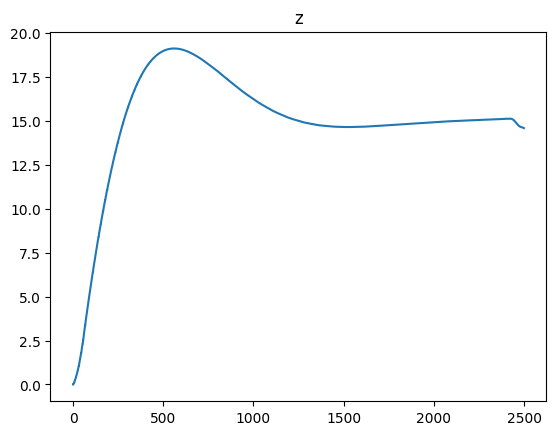

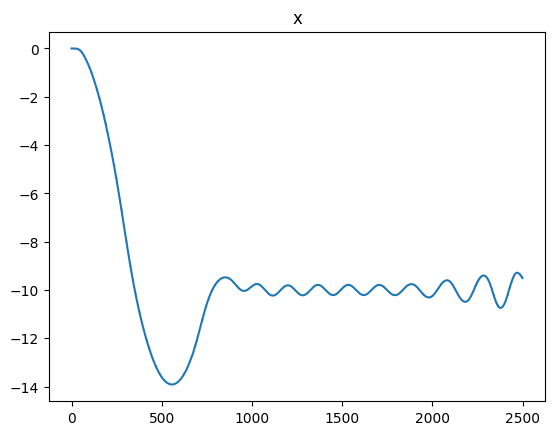

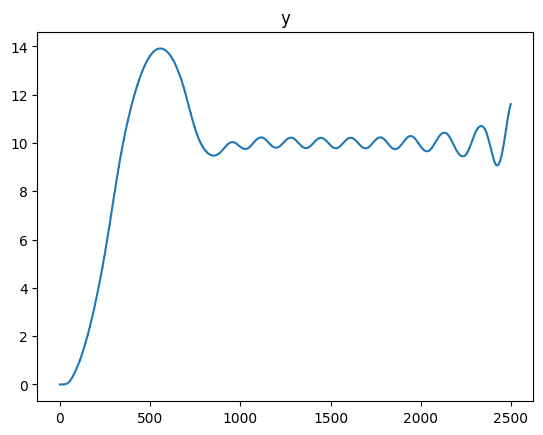

In [12]:
plt.title("z")
plt.plot(positions[:, 2])
plt.show()

plt.title("x")
plt.plot(positions[:, 0])
plt.show()

plt.title("y")
plt.plot(positions[:, 1])
plt.show()